# GPcounts on bulk dataset

Nuha BinTayyash, 2020

This notebook shows how to run [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) R package to normalize [fission yeast](https://bioconductor.org/packages/release/data/experiment/html/fission.html) gene expression data. Then, compare GPcounts with negative binomial likelihood and Gaussian likelihood to find differentially expressed genes in one sample test and two-sample tests.

### load [fission dataset](https://bioconductor.org/packages/3.11/data/experiment/html/fission.html) and normalize it using DESeq2

In [ ]:
library("fission")
data("fission")
counts <- SummarizedExperiment::assay(fission)
keep <- rowMeans(counts) >1
counts <- counts[keep,]
col_data <- fission@colData
write.csv(counts, file = "fission_counts.csv")
write.csv(col_data, file = "fission_col_data.csv")

wt_counts <- counts[,1:18]
wt_col_data <- col_data[1:18,]
write.csv(wt_counts, file = "wt_counts.csv")
write.csv(wt_col_data, file = "wt_col_data.csv")
dim(counts)

DESeq2 two samples test

In [ ]:
#col_data_scaled <- read.csv(file = 'fission_col_data_scaled.csv',row.names = 1, header = TRUE)

library("DESeq2")
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = col_data,
                              design = ~ strain + minute + strain:minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
dim(normalized_counts)
write.csv(normalized_counts, file = "fission_normalized_counts.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ strain + minute)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_tst.csv")

In [ ]:
col_data_scaled <- read.csv(file = 'wt_col_data_scaled.csv',row.names = 1, header = TRUE)

dds <- DESeqDataSetFromMatrix(countData = wt_counts,
                              colData = col_data_scaled,
                              design = ~  minute)

dds <- estimateSizeFactors(dds)
normalized_counts<-counts(dds, normalized=TRUE)
write.csv(normalized_counts, file = "wt_normalized_counts.csv")

dds <- DESeq(dds, test="LRT", reduced = ~ 1)
res <- results(dds)
write.csv(as.data.frame(res),file="fission_DESeq2_ost.csv")

#### Change R kernel to Python kernel

In [1]:
import numpy as np
import pandas as pd
import gpflow

In [2]:
filename = 'fission_normalized_counts.csv'
#filename = 'wt_normalized_counts_scaled52.csv'
Y = pd.read_csv(filename,index_col=[0])
X = pd.read_csv('fission_col_data.csv',index_col=[0])
X = X[['minute']]
#X.iloc[0:18,:]

Fit some fission gene normalized data using GPcounts -- Two samples test

In [3]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    c = 'royalblue'
    
    if model_index == 3:
        c = 'green'
    
    plt.plot(xtest, mean,color= c, lw=2) 
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),color=c,alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color=c, alpha=0.1)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,color=c,alpha=0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color=c,alpha=0.1)
    
    if test == 'Two_samples_test' and model_index == 1:
        plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'royalblue',alpha=1.) #data    
        plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='o', color= 'green',alpha=1.) #data

    else: 
        plt.scatter(model.data[0],model.data[1],s=30,marker = 'o',color=c,alpha=1.)
    
    
    if not(test == 'Two_samples_test' and model_index == 2):
        plt.show()
    

In [9]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
genes_name = [
'SPAC212.04c',
 'SPAC1F8.06',
 'SPAC11D3.01c',
 'SPAC11D3.02c',
 'SPNCRNA.609',
 'SPAC5H10.06c',
 'SPAC5H10.10',
 'SPNCRNA.624',
 'SPNCRNA.628',
 'SPAC18B11.07c',
 'SPAC12G12.15',
 'SPAC12G12.14c',
 'SPNCRNA.638',
 'SPAC12G12.03',
 'SPATRNAPRO.01',
 'SPAC1751.02c',
 'SPNCRNA.653',
 'SPNCRNA.654',
 'SPAC227.19c',
 'SPAC227.05']
'''
 'SPAC227.11c',
 'SPAC1F3.05',
 'SPAC1D4.01',
 'SPAC1D4.05c',
 'SPAC1296.05c',
 'SPAC222.04c',
 'SPAC222.16c',
 'SPAC821.05',
 'SPNCRNA.220',
 'SPAC1A6.01c',
 'SPAC1A6.04c',
 'SPAC19E9.01c',
 'SPAC3A12.11c',
 'SPAC3A12.15',
 'SPAC5D6.10c',
 'SPAC167.04',
 'SPAC167.09',
 'SPAC23H4.17c',
 'SPAP27G11.03',
 'SPAC17A5.16',
 'SPAP11E10.02c',
 'SPAPB1A10.11c',
 'SPNCRNA.775',
 'SPAC9G1.05',
 'SPAC17H9.07',
 'SPNCRNA.186',
 'SPAC631.01c',
 'SPAC23C11.07',
 'SPAC1783.01',
 'SPAC18G6.03',
 'SPAC4G9.04c',
 'SPAC13G7.04c',
 'SPAC17G8.15',
 'SPAC15F9.01c',
 'SPAC32A11.01',
 'SPAC19A8.06',
 'SPAC23H3.07c',
 'SPAC823.09c',
 'SPAC7D4.13c',
 'SPAC7D4.10',
 'SPNCRNA.842',
 'SPAC7D4.02c',
 'SPAC4F8.08',
 'SPSNORNA.54',
 'SPNCRNA.205',
 'SPAC1B2.05',
 'SPAC3F10.04',
 'SPNCRNA.855',
 'SPAC8F11.08c',
 'SPNCRNA.56',
 'SPAPB24D3.03',
 'SPAPB24D3.10c',
 'SPNCRNA.71',
 'SPNCRNA.01',
 'SPAC31G5.14',
 'SPAC3G9.15c',
 'SPAC3G9.11c',
 'SPAC328.05',
 'SPAC16E8.15',
 'SPAC1B1.01',
 'SPAC17G6.04c',
 'SPAC8C9.11',
 'SPAC15A10.17',
 'SPAC15A10.08',
 'SPNCRNA.941',
 'SPAC1071.06',
 'SPAC2F3.02',
 'SPAC2F3.18c',
 'SPAC2F3.11',
 'SPAC19G12.02c',
 'SPSNORNA.13',
 'SPAC21E11.05c',
 'SPAC21E11.08',
 'SPAC27F1.02c',
 'SPNCRNA.980',
 'SPAC16.03c',
 'SPAC17C9.01c',
 'SPAC637.06',
 'SPAC637.11']
 '''
gp_counts = Fit_GPcounts(X,Y.loc[genes_name])
log_likelihoods = gp_counts.Two_samples_test(likelihood)
log_likelihoods


100%|██████████| 20/20 [03:59<00:00, 11.97s/it]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio,time,failure counter
SPAC212.04c,-164.781063,-76.439054,-84.904826,3.437184,0:00:13.321218,1
SPAC1F8.06,-185.959533,-93.161305,-91.425044,1.373184,0:00:17.066533,1
SPAC11D3.01c,-230.955320,-120.988723,-105.931814,4.034783,0:00:09.849169,0
SPAC11D3.02c,-242.529795,-118.636893,-120.979986,2.912915,0:00:07.046180,0
SPNCRNA.609,-196.600947,-102.299948,-97.083286,-2.782287,0:00:22.619661,0
SPAC5H10.06c,-220.335935,-113.284307,-106.935704,0.115924,0:00:14.781612,4
SPAC5H10.10,-210.031202,-104.501725,-108.730211,-3.200734,0:00:11.006171,0
SPNCRNA.624,-167.685510,-91.314936,-80.474277,-4.103702,0:00:08.742943,0
SPNCRNA.628,-74.252783,-30.286644,-42.233759,1.732380,0:00:02.811697,0
SPAC18B11.07c,-199.586749,-99.777608,-101.714379,-1.905238,0:00:20.329883,2



100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


SPAC212.04c


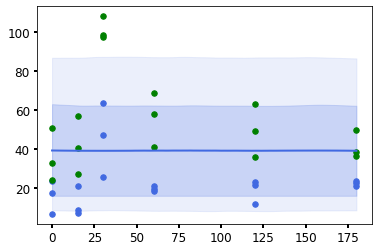

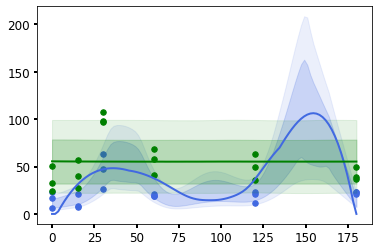

SPAC1F8.06


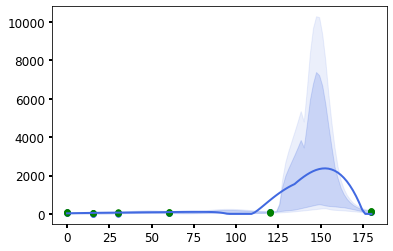

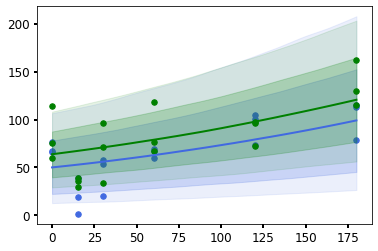

SPAC11D3.01c


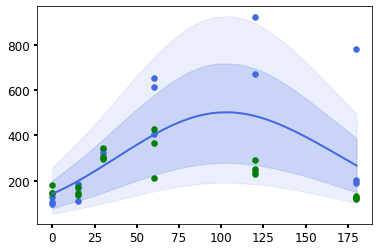

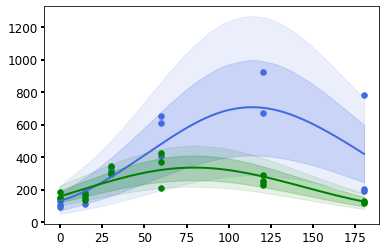

SPAC11D3.02c


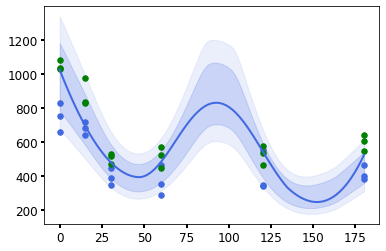

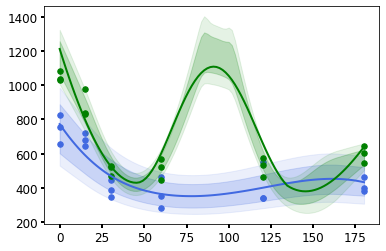

SPNCRNA.609


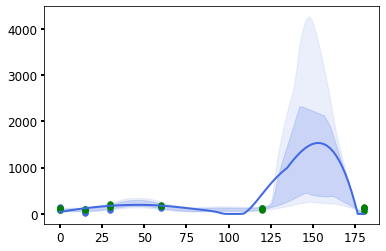

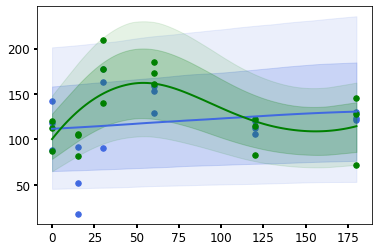

SPAC5H10.06c


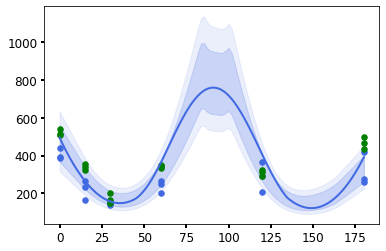

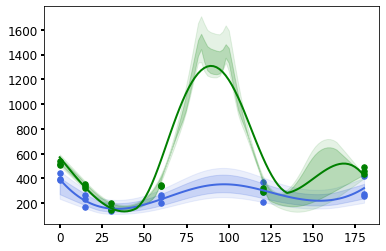

SPAC5H10.10


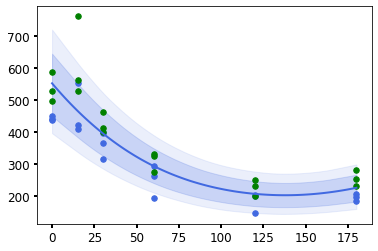

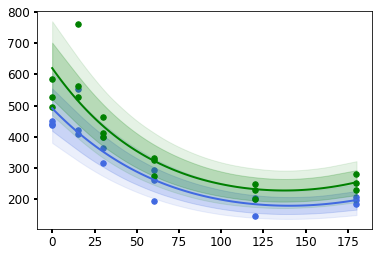

SPNCRNA.624


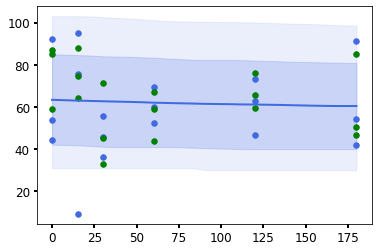

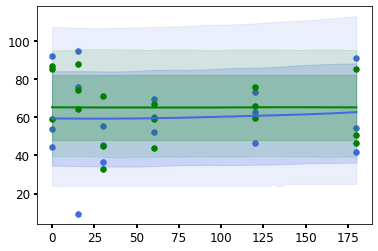

SPNCRNA.628


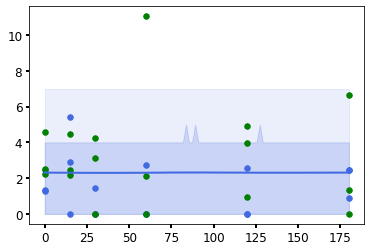

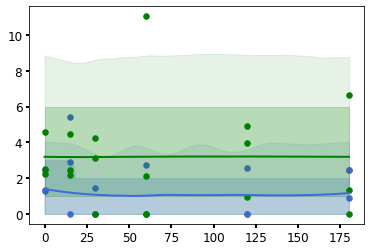

SPAC18B11.07c


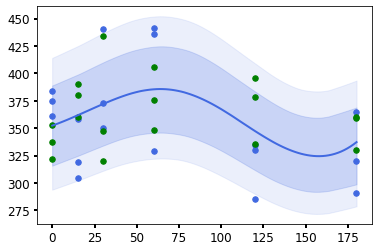

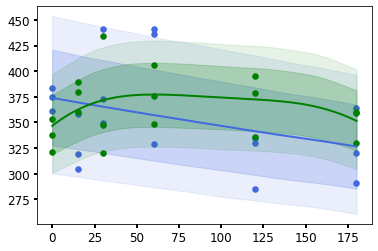

SPAC12G12.15


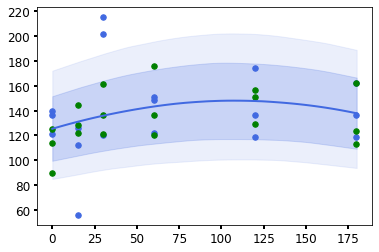

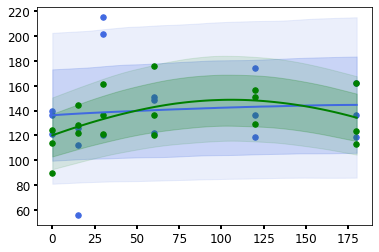

SPAC12G12.14c


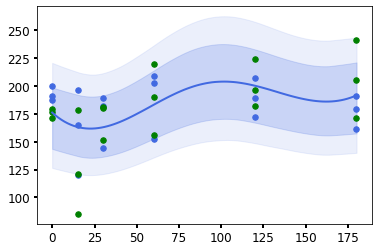

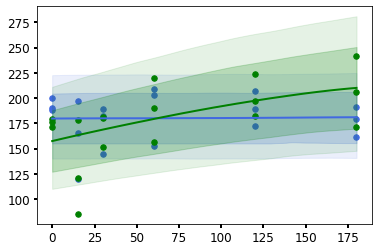

SPNCRNA.638


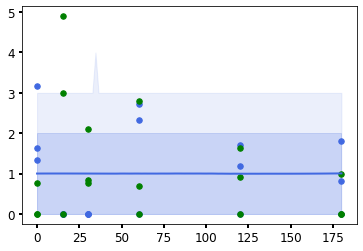

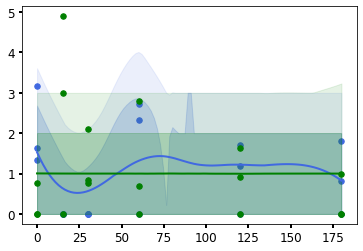

SPAC12G12.03


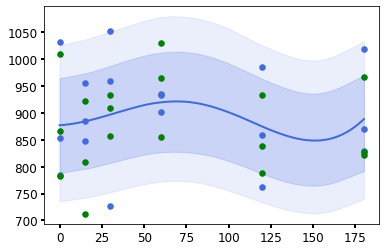

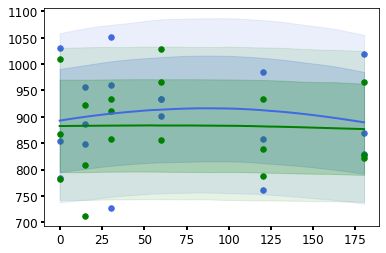

SPATRNAPRO.01


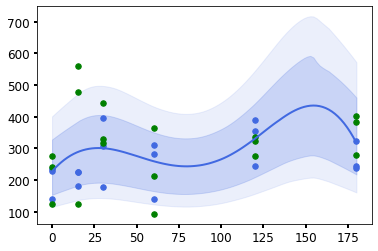

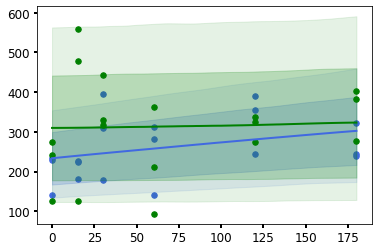

SPAC1751.02c


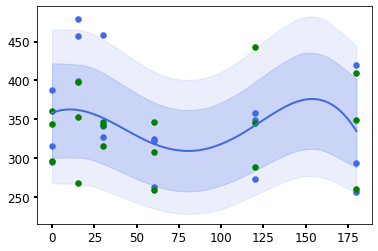

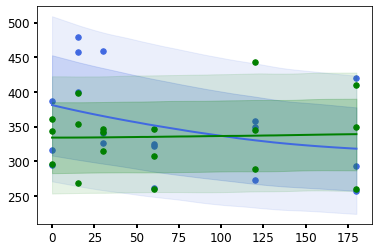

SPNCRNA.653


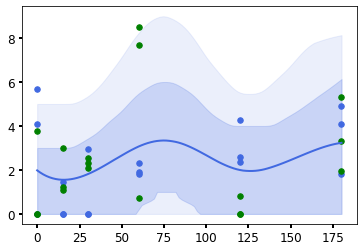

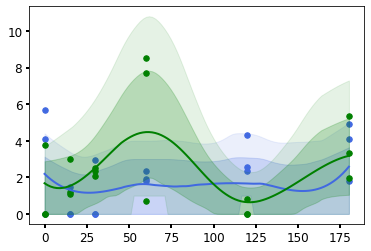

SPNCRNA.654


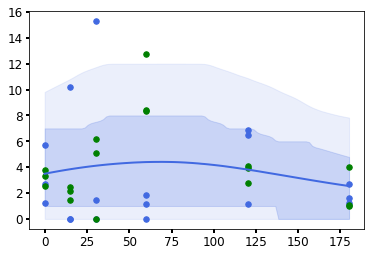

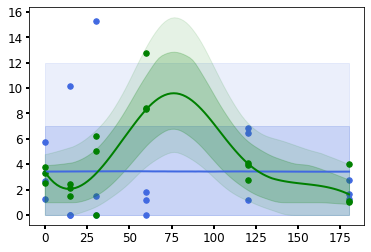

SPAC227.19c


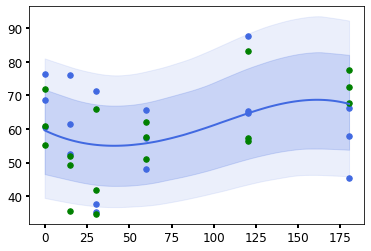

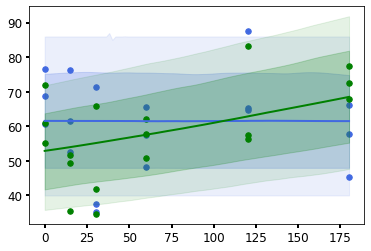

SPAC227.05


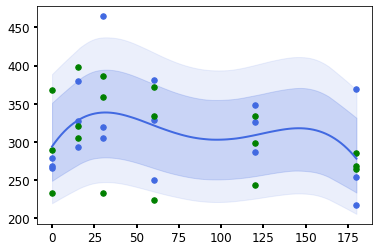

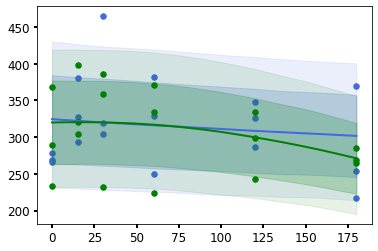

In [10]:
indexes = log_likelihoods.index.values # list of genes to be plotted 
test = 'Two_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for mean,var,model in zip(params['means'][i],params['vars'][i],params['models'][i]):
        plot() 
        model_index = model_index + 1

In [11]:
likelihood = 'Gaussian'
log_likelihoods = gp_counts.Two_samples_test(likelihood)
log_likelihoods


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


,Shared_log_likelihood,model_1_log_likelihood,model_2_log_likelihood,log_likelihood_ratio,time,failure counter
SPAC212.04c,-39.503635,-22.464042,-17.756339,-0.716747,0:00:00.697352,0
SPAC1F8.06,-43.489392,-30.519727,-20.245043,-7.275378,0:00:00.679196,0
SPAC11D3.01c,-29.480800,-18.182720,-13.617617,-2.319537,0:00:00.690200,0
SPAC11D3.02c,-9.840665,-7.402831,-4.374226,-1.936392,0:00:00.680911,0
SPNCRNA.609,-29.643019,-24.133656,-10.414174,-4.904811,0:00:00.660214,0
SPAC5H10.06c,-14.576392,-12.492405,-2.990844,-0.906857,0:00:00.664437,0
SPAC5H10.10,-0.913599,-1.562554,-1.973841,-2.622797,0:00:00.684030,0
SPNCRNA.624,-22.538041,-16.614139,-6.223019,-0.299117,0:00:01.759143,1
SPNCRNA.628,-40.756707,-20.019974,-21.163005,-0.426272,0:00:00.687574,0
SPAC18B11.07c,23.127788,6.160783,13.605724,-3.361281,0:00:00.952318,0



100%|██████████| 20/20 [00:01<00:00, 13.55it/s]


SPAC212.04c


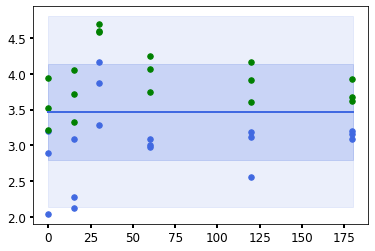

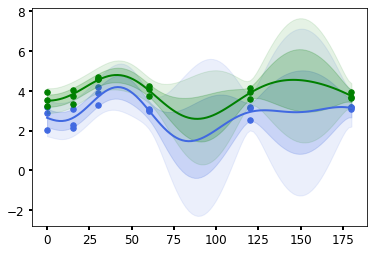

SPAC1F8.06


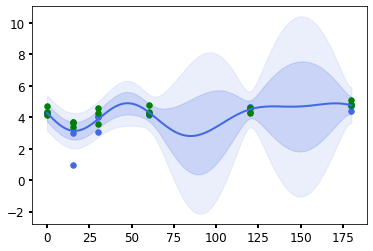

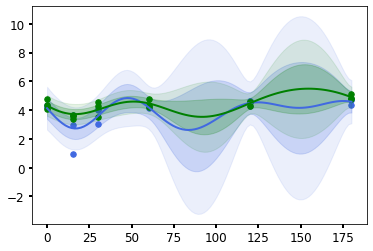

SPAC11D3.01c


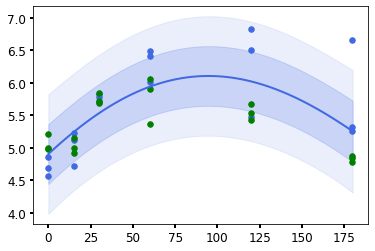

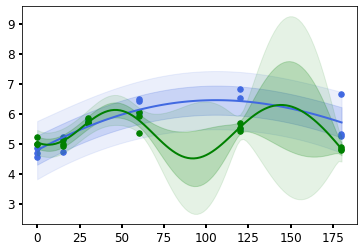

SPAC11D3.02c


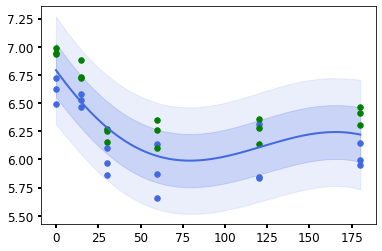

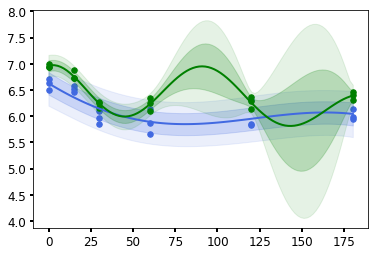

SPNCRNA.609


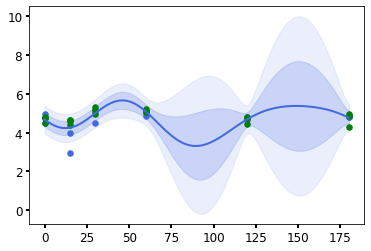

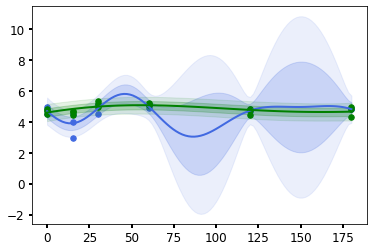

SPAC5H10.06c


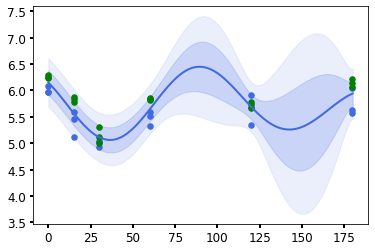

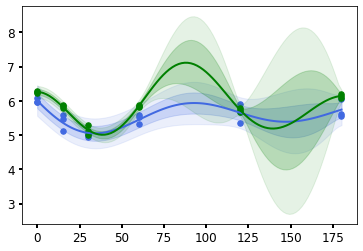

SPAC5H10.10


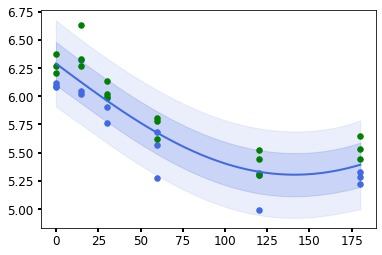

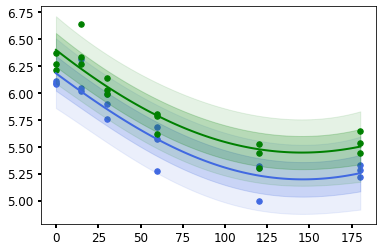

SPNCRNA.624


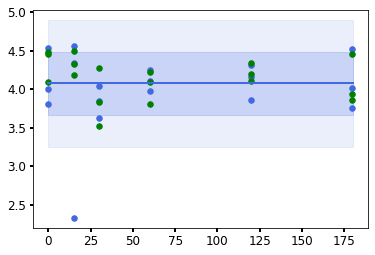

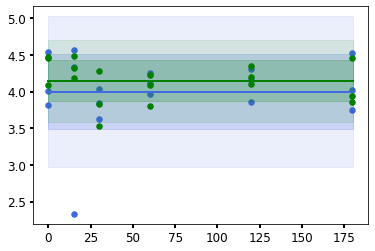

SPNCRNA.628


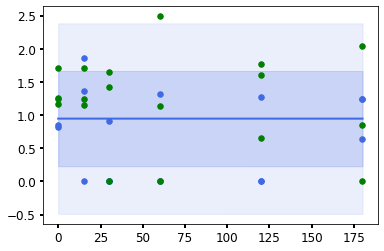

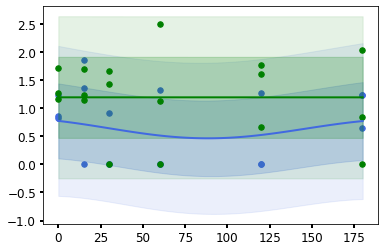

SPAC18B11.07c


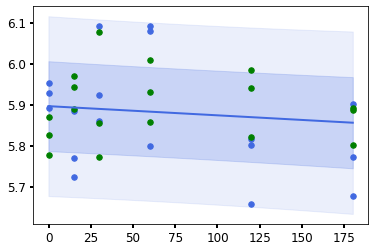

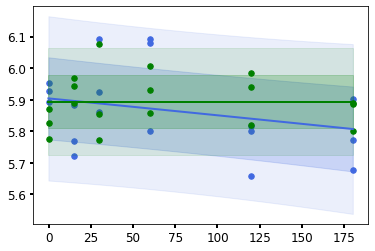

SPAC12G12.15


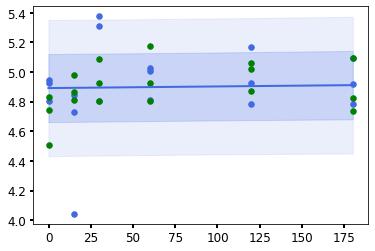

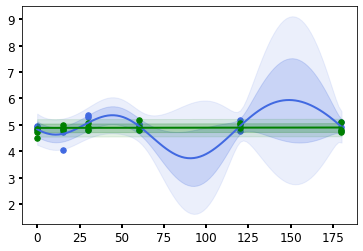

SPAC12G12.14c


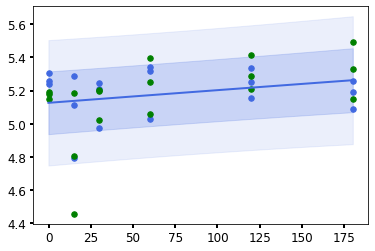

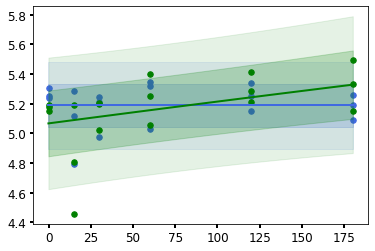

SPNCRNA.638


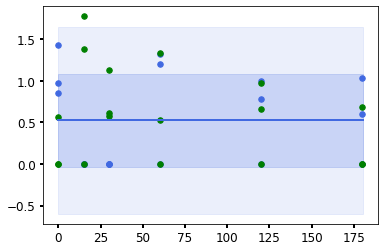

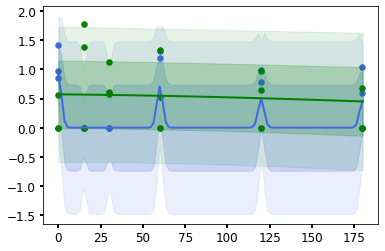

SPAC12G12.03


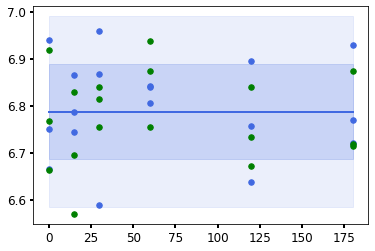

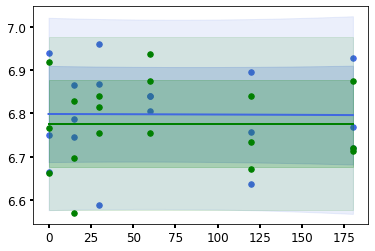

SPATRNAPRO.01


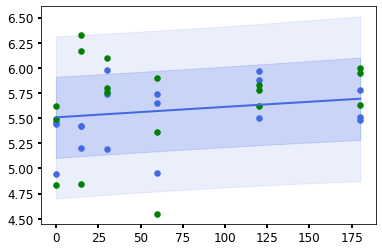

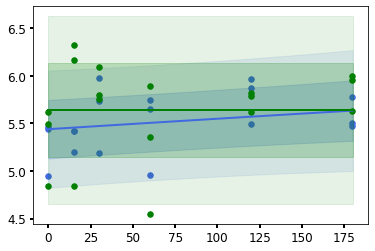

SPAC1751.02c


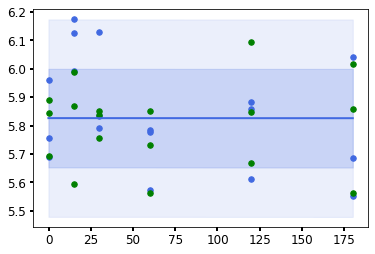

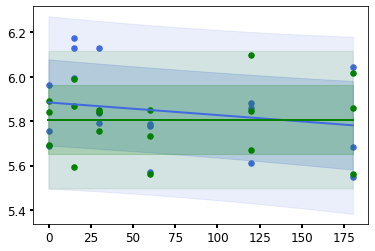

SPNCRNA.653


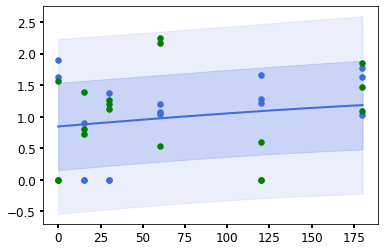

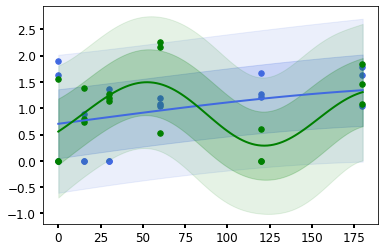

SPNCRNA.654


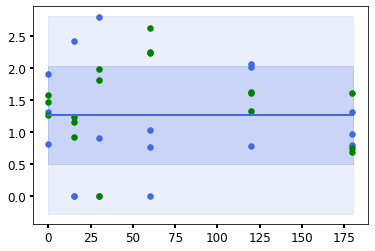

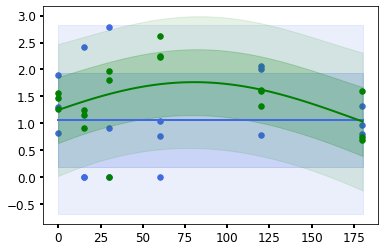

SPAC227.19c


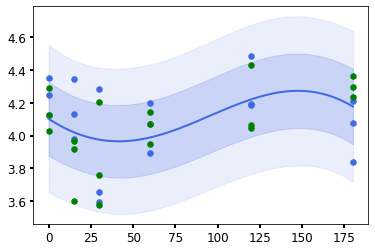

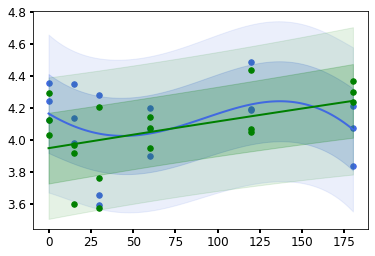

SPAC227.05


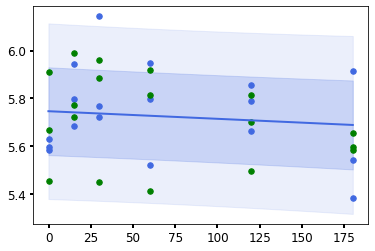

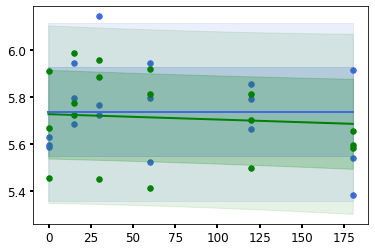

In [12]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

In [ ]:
from GPcounts.GPcounts_Module import Fit_GPcounts
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X.iloc[0:18,:],Y.iloc[:,0:18].loc[genes_name])
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

In [ ]:
indexes = log_likelihood_ratio.index.values # list of genes to be plotted 
test = 'One_samples_test' # name of the test
xtest = np.linspace(np.min(X.values)-.1,np.max(X.values)+.1,100)[:,None] # points to make prediction

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1